# Script E: Simulating Power in within-subject psycholinguistic

experiments using unstandardized measures of effect size

Diogo Almeida & Roberto Petrosino

# Functions used in the calculations

In [ ]:
#| eval: false
library(ggplot2)
library(MASS)

# --- Utility Functions --- #

invert_argument_docall <- function(func){
  function(data){
    do.call(func, data)
  }
} 

rbind_list <- invert_argument_docall(rbind)

matcols2lists <- function(data_matrix, group_by = 2) {
  ncols <- ncol(data_matrix)
  stopifnot(!(ncols%%group_by))
  start_indices <- seq(from = 1, to = ncols, by = group_by)
  n_conditions <- length(start_indices)
  grouped_conditions <- vector(mode = "list", length = n_conditions)
  for (first_item in start_indices) {
    grouped_conditions[[which(start_indices == first_item)]] <- data_matrix[, seq(first_item, first_item + group_by - 1)]
  }
  grouped_conditions
}

organize_output <- function(simdata_list) {
  step_1 <- lapply(simdata_list, FUN = t)
  n_conds <- ncol(step_1[[1]])
  n_measures <- nrow(step_1[[1]])
  measure_labels <- rownames(step_1[[1]])
  c_lbl <- paste0("cond", rep(1:n_conds, each = n_measures), "_", rep(measure_labels, n_conds))
  step_2 <- step_1 |>
    rapply(as.vector, how = "list") |>
    rbind_list()
  colnames(step_2) <- c_lbl
  step_2 |>
    matcols2lists(group_by = n_measures)
}

combine_sims <- function(sim_list) {
  n_conds <- nrow(sim_list[[1]])
  n_sims <- length(sim_list)
  sim_df <- rbind_list(sim_list)
  sim_df[["simulation"]]  <- paste0("simulation_", rep(1:n_sims, each = n_conds))
  sim_df[["condition"]] <- paste0("condition_", rep(1:n_conds, times = n_sims))
  sim_df
}

# --- Statistical Functions --- # 

correlation2covariance <- function(cor_mat, sd_var = 50) {
  sweep(sweep(cor_mat, 1L, sd_var, "*"), 2L, sd_var, "*")  
}

calc_cov_mat <- function(rho, std_dev, ncond = 2) {
  corr_matrix <- matrix(rep(rho, times = ncond^2), ncol = ncond)
  diag(corr_matrix) <- 1
  cov_matrix <- correlation2covariance(cor_mat = corr_matrix, sd_var = std_dev)
  cov_matrix
}

fast_t <- function(data_matrix) {
  diff <- data_matrix[, 1] - data_matrix[, 2]
  n <- length(diff)
  deg_fre <- n - 1
  sd_diff <- sd(diff)
  se_diff <- sd_diff / sqrt(n)
  mean_diff <- mean(diff)
  t_val <- mean_diff / se_diff
  t_crit <- qt(.975, df = deg_fre)
  conf.int <- c(mean_diff - (t_crit * se_diff), mean_diff + (t_crit * se_diff))
  p_val <- pt(-abs(t_val), df = deg_fre, lower.tail = TRUE) * 2 # change this for one-tail
  list(statistic = t_val, parameter = deg_fre, p.value = p_val, conf.int = conf.int, 
       estimate = mean_diff, stderr = se_diff)
}

t_test_paired_data <- function(paired_data, fast = TRUE, use_names = TRUE,
                               info_out = c("estimate", "statistic", "p.value")) {
  if (fast) {
    test_result <- fast_t(paired_data)[info_out] |>
      unlist()
  } else {
    test_result <- t.test(paired_data[, 1], paired_data[, 2], paired = TRUE)[info_out] |>
      unlist()
  }
  if(use_names) {
    true_means <- as.numeric(sub("C[0-9]+_", "", colnames(paired_data)))
    true_es <- true_means[1] - true_means[2]
    test_result <- c(true_es, test_result)
  } else {
    test_result <- c(NA, test_result)
  }
  names(test_result) <- c("true_es", "estimate", "statistic", "p.value")
  test_result
}

test_2x2_paired_data <- function(sim_results,rename_cols = TRUE) {
  main1 <- t_test_paired_data(sim_results[, 1:2])
  main2 <- t_test_paired_data(sim_results[, 3:4])
  diff1 <- sim_results[, 1] - sim_results[, 2]
  diff2 <- sim_results[, 3] - sim_results[, 4]
  diff_diff <- cbind(diff1, diff2)
  diff_es <- c(main1["true_es"], main2["true_es"])
  colnames(diff_diff) <- paste0("C", seq(diff_es), "_", diff_es)
  interaction <- t_test_paired_data(diff_diff)
  output <-  rbind(main1, main2, interaction) |>
    transform(p.adjust = p.adjust(p.value, "holm"))
  output[["condition"]] <- rownames(output)
  output
}

calc_error_design <- function(sim_results, alpha = .05, rename_cols = TRUE) {
  stopifnot(rename_cols)
  col_labels <- colnames(sim_results)
  colnames(sim_results) <- sub("cond[0-9]+_", "", col_labels)

  sig_subset_unadjusted <- subset(as.data.frame(sim_results), p.value < alpha)
  sig_subset_adjusted <- subset(as.data.frame(sim_results), p.adjust < alpha)
  sim_true_es <- mean(sig_subset_unadjusted$true_es)
  nsim <- nrow(sim_results)
  nsig_unadjusted <- nrow(sig_subset_unadjusted)
  nsig_adjusted <- nrow(sig_subset_adjusted)
  power_unadjusted <- nsig_unadjusted / nsim
  power_adjusted <- nsig_adjusted / nsim
  type_s_unadjusted <- nrow(subset(sig_subset_unadjusted, estimate < 0)) / nsig_unadjusted
  type_s_adjusted <- nrow(subset(sig_subset_adjusted, estimate < 0)) / nsig_adjusted
  exaggeration_ratio_unadjusted <- with(sig_subset_unadjusted, 
                                        mean(abs(estimate)) / mean(true_es))
  exaggeration_ratio_adjusted <- with(sig_subset_adjusted, 
                                      mean(abs(estimate)) / mean(true_es))
  errors <- c(ES = sim_true_es,
              power_unadjusted = power_unadjusted,
              type_s_unadjusted = type_s_unadjusted,
              exaggeration_ratio_unadjusted = exaggeration_ratio_unadjusted,
              power_adjusted = power_adjusted,
              type_s_adjusted = type_s_adjusted,
              exaggeration_ratio_adjusted = exaggeration_ratio_adjusted)
  errors
}

# --- Simulation Functions --- #

simulate_data_from_es <- function(es, base_mu = 600) {
  function(rho, std_dev, nsubj) {
    condition_means <- as.vector(es + base_mu)
    list(rho, std_dev)
    cov_mat <- calc_cov_mat(rho, std_dev, ncond = length(es))  # one rho all conds
    #cov_mat
    simulation <- MASS::mvrnorm(n = nsubj, mu = condition_means, Sigma = cov_mat,
                                empirical = FALSE)
    colnames(simulation) <- paste0("C", seq(condition_means), "_", condition_means)
    simulation
  }
}

do_sim <- function(sim_params, sim_func, Nsim = 5000, alpha = 0.05){
  replicate(Nsim, do.call(sim_func, sim_params), simplify = FALSE) |>
    lapply(FUN = matcols2lists, group_by = 2) |>
    rapply(t_test_paired_data, how = "list") |>
    lapply(FUN = rbind_list) |>
    lapply(FUN = transform, p.adjust = p.adjust(p.value, "holm")) |>
    organize_output() |>
    lapply(FUN = calc_error_design, alpha = alpha) |>
    rbind_list() |>
    data.frame(sim_params)
}

do_sim_2x2 <- function(sim_params, sim_func, Nsim = 5000, alpha = 0.05) {
  replicate(Nsim, do.call(sim_func, sim_params), simplify = FALSE) |>
    lapply(FUN = matcols2lists, group_by = 4) |>
    rapply(test_2x2_paired_data, how = "list" )  |>
    unlist(recursive = FALSE) |>
    rbind_list() |>
    split(~condition) |>
    lapply(FUN = calc_error_design, alpha = alpha) |>
    rbind_list() |>
    data.frame(sim_params)
}

# Simulating possible scenarios for the Frequency Attenuation effect in Masked Priming

Seventeen studies were found in the literature about frequency attenuation. Out of these:

-   All show the repetition effect for both HF and LF words.

-   Only three show a statistically significant interaction between identity priming and frequency (with lower frequency words showing more masked id priming). The effect sizes on these three are quite large (30, 31 and 32 ms), about as large as the corresponding masked id priming for HF in the experiment.

Thus, it seems reasonable that there may be a frequency attenuation effect, but what is its actual size? The experiments that detected it found a very large one, but this seems a rare event: if the effect size really is that large, why aren’t we finding the interaction as often as the main effects? The inconsistency of past findings regarding the FAE in masked priming has been linked to a potential lack of statistical power in previous research \[@BodnerMasson1997; @BodnerMasson2001; @MassonBodner2003; @Adelman2014\]. This is a reasonable concern, as interactions like the FAE often require larger sample sizes for statistical detection \[@PotvinSchtuz2000; @BrysbaertStevens2018\] compared to main effects.

We ran an extensive power analysis to determined the sample size large enough to guarantee an acceptable statistical power ($>80%$) able to detect what we construed as the smallest theoretically interesting FAE (i.e., 5ms). To this end, the code below simulates 10,000 datasets for each of the combinations of the following parameters:

1.  Standard deviation and correlation between related and unrelated condition. Based on our own pilot studies and previous published work \[@Petrosino2020; @PetrosinoEtal2023\], the simulations involved standard deviations ranging from 80 to 120 ms (with 10 ms increments), while the correlation between conditions ranged from 0.7 to 0.9 (with 0.1 increments). T
2.  Sample size, ranging between 200 and 3000 participants (with 150-participant increments)
3.  Three FAE sizes were simulated: 15 ms, 10 ms and 5 ms. The first effect size (15 ms) is about half of the ones observed in previous studies that statistically detected the FAE (~30 ms). The second effect size (10 ms) is close to the size of the average frequency attenuation effect found in the literature (13 ms). The last effect size (5 ms) is our lower-bound estimate of a theoretically interesting effect size.

### ES = 5 ms

In [ ]:
#| eval: false
#| cache: true

## Simulation of simple effects: Using a matrix of possible parameters
freq_atten_sim.5ms_Nsim <- 10000

# ---- range of Effect Sizes ------#
# ---- range of DD Effect Sizes ------#
freq_atten_sim.5ms_base_es <- 60
freq_atten_sim.5ms_dd_to_sim <- freq_atten_sim.5ms_base_es - c(30, 25) # this will create the 2x2 design in which each pair will represent the unrelated and related level of each condition (e.g., high and low frequency). So the two values in the second term of the difference are the actual priming effects of the two conditions of the 2x2 factorial design. These priming effects will be analyzed in a paired t-test in each of the 10,000 simulations of each combination of sample size, sd, and rho. 

# ---- design ----#
freq_atten_sim.5ms_design <- expand.grid(freq_atten_sim.5ms_base_es, freq_atten_sim.5ms_dd_to_sim) |>
  t() |>
  as.vector() |>
  setNames(paste0("ES", 1:(length(freq_atten_sim.5ms_dd_to_sim)*2)))

# ---- range of N ------#
freq_atten_sim.5ms_n_subjs_to_sim <- seq(200, 3000, by = 150)

# ---- range of SDs ------#
freq_atten_sim.5ms_min_sd <- 60
freq_atten_sim.5ms_max_sd <- 180
freq_atten_sim.5ms_sd_increment <- 10
freq_atten_sim.5ms_sds_to_sim <- seq(from = freq_atten_sim.5ms_min_sd, to = freq_atten_sim.5ms_max_sd, 
                                by = freq_atten_sim.5ms_sd_increment)

# ---- range of rhos ------#
freq_atten_sim.5ms_min_rho <- .6
freq_atten_sim.5ms_max_rho <- .9
freq_atten_sim.5ms_rho_increment <- .1
freq_atten_sim.5ms_rhos_to_sim <- seq(from = freq_atten_sim.5ms_min_rho, to = freq_atten_sim.5ms_max_rho, 
                                 by = freq_atten_sim.5ms_rho_increment)

# ---- create the control matrix ---- #
freq_atten_sim.5ms_simulation_params <- expand.grid(freq_atten_sim.5ms_rhos_to_sim,
                                               freq_atten_sim.5ms_sds_to_sim,
                                               freq_atten_sim.5ms_n_subjs_to_sim)
colnames(freq_atten_sim.5ms_simulation_params) <- c("rho", "std_dev", "nsubj")
freq_atten_sim.5ms_simulate_effects <- simulate_data_from_es(freq_atten_sim.5ms_design)
freq_atten_sim.5ms_params <- freq_atten_sim.5ms_simulation_params |>
  split(seq(nrow(freq_atten_sim.5ms_simulation_params))) |>
  lapply(FUN = as.list)

### Run simulation
set.seed(20140715)
t0 <- Sys.time()
freq_atten_sim.5ms_df <- lapply(freq_atten_sim.5ms_params, do_sim_2x2, 
                               freq_atten_sim.5ms_simulate_effects, 
                               Nsim = freq_atten_sim.5ms_Nsim) |>
  combine_sims()
Sys.time() - t0
save("freq_atten_sim.5ms_df", file = "freq_atten_sim.5ms.RData", compress=TRUE)

load("freq_atten_sim.5ms.RData")

## Plotting
freq_atten_sim.5ms_df |>
  subset(ES == 5) |>
  ggplot(aes(x = nsubj, y = power_unadjusted)) + 
    geom_line(aes()) + 
    geom_point() +
    geom_hline(yintercept = c(0.8, 0.5, 0.1), color = "red2") + 
    facet_grid(rho ~ std_dev) 

### ES = 10 ms

In [ ]:
#| cache: true
#| eval: false

## Simulation of simple effects: Using a matrix of possible parameters
freq_atten_sim.10ms_Nsim <- 10000

# ---- range of Effect Sizes ------#
# ---- range of DD Effect Sizes ------#
freq_atten_sim.10ms_base_es <- 60
freq_atten_sim.10ms_dd_to_sim <- freq_atten_sim.10ms_base_es - c(30, 20) # this will create the 2x2 design in which each pair will represent the unrelated and related level of each condition (e.g., high and low frequency). So the two values in the second term of the difference are the actual priming effects of the two conditions of the 2x2 factorial design. These priming effects will be analyzed in a paired t-test in each of the 10,000 simulations of each combination of sample size, sd, and rho. 

# ---- design ----#
freq_atten_sim.10ms_design <- expand.grid(freq_atten_sim.10ms_base_es, freq_atten_sim.10ms_dd_to_sim) |>
  t() |>
  as.vector() |>
  setNames(paste0("ES", 1:(length(freq_atten_sim.10ms_dd_to_sim)*2)))

# ---- range of N ------#
freq_atten_sim.10ms_n_subjs_to_sim <- seq(200, 3000, by = 150)

# ---- range of SDs ------#
freq_atten_sim.10ms_min_sd <- 60
freq_atten_sim.10ms_max_sd <- 180
freq_atten_sim.10ms_sd_increment <- 10
freq_atten_sim.10ms_sds_to_sim <- seq(from = freq_atten_sim.10ms_min_sd, to = freq_atten_sim.10ms_max_sd, 
                                by = freq_atten_sim.10ms_sd_increment)

# ---- range of rhos ------#
freq_atten_sim.10ms_min_rho <- .6
freq_atten_sim.10ms_max_rho <- .9
freq_atten_sim.10ms_rho_increment <- .1
freq_atten_sim.10ms_rhos_to_sim <- seq(from = freq_atten_sim.10ms_min_rho, to = freq_atten_sim.10ms_max_rho, 
                                 by = freq_atten_sim.10ms_rho_increment)

# ---- create the control matrix ---- #
freq_atten_sim.10ms_simulation_params <- expand.grid(freq_atten_sim.10ms_rhos_to_sim,
                                               freq_atten_sim.10ms_sds_to_sim,
                                               freq_atten_sim.10ms_n_subjs_to_sim)
colnames(freq_atten_sim.10ms_simulation_params) <- c("rho", "std_dev", "nsubj")
freq_atten_sim.10ms_simulate_effects <- simulate_data_from_es(freq_atten_sim.10ms_design)
freq_atten_sim.10ms_params <- freq_atten_sim.10ms_simulation_params |>
  split(seq(nrow(freq_atten_sim.10ms_simulation_params))) |>
  lapply(FUN = as.list)

### Run simulation
set.seed(20140715)
t0 <- Sys.time()
freq_atten_sim.10ms_df <- lapply(freq_atten_sim.10ms_params, do_sim_2x2, 
                               freq_atten_sim.10ms_simulate_effects, 
                               Nsim = freq_atten_sim.10ms_Nsim) |>
  combine_sims()
Sys.time() - t0
save("freq_atten_sim.10ms_df", file = "freq_atten_sim.10ms.RData", compress=TRUE)


load("freq_atten_sim.10ms.RData")

## Plotting
freq_atten_sim.10ms_df |>
  subset(ES == 10) |>
  ggplot(aes(x = nsubj, y = power_unadjusted)) + 
    geom_line(aes()) + 
    geom_point() +
    geom_hline(yintercept = c(0.8, 0.5, 0.1), color = "red2") + 
    facet_grid(rho ~ std_dev) 

### ES = 15 ms

In [ ]:
#| cache: true
#| eval: false

## Simulation of simple effects: Using a matrix of possible parameters
freq_atten_sim.15ms_Nsim <- 10000

# ---- range of Effect Sizes ------#
# ---- range of DD Effect Sizes ------#
freq_atten_sim.15ms_base_es <- 60
freq_atten_sim.15ms_dd_to_sim <- freq_atten_sim.15ms_base_es - c(30, 15) # this will create the 2x2 design in which each pair will represent the unrelated and related level of each condition (e.g., high and low frequency). So the two values in the second term of the difference are the actual priming effects of the two conditions of the 2x2 factorial design. These priming effects will be analyzed in a paired t-test in each of the 10,000 simulations of each combination of sample size, sd, and rho. 

# ---- design ----#
freq_atten_sim.15ms_design <- expand.grid(freq_atten_sim.15ms_base_es, freq_atten_sim.15ms_dd_to_sim) |>
  t() |>
  as.vector() |>
  setNames(paste0("ES", 1:(length(freq_atten_sim.15ms_dd_to_sim)*2)))

# ---- range of N ------#
freq_atten_sim.15ms_n_subjs_to_sim <- seq(200, 3000, by = 150)

# ---- range of SDs ------#
freq_atten_sim.15ms_min_sd <- 60
freq_atten_sim.15ms_max_sd <- 180
freq_atten_sim.15ms_sd_increment <- 10
freq_atten_sim.15ms_sds_to_sim <- seq(from = freq_atten_sim.15ms_min_sd, to = freq_atten_sim.15ms_max_sd, 
                                by = freq_atten_sim.15ms_sd_increment)

# ---- range of rhos ------#
freq_atten_sim.15ms_min_rho <- .6
freq_atten_sim.15ms_max_rho <- .9
freq_atten_sim.15ms_rho_increment <- .1
freq_atten_sim.15ms_rhos_to_sim <- seq(from = freq_atten_sim.15ms_min_rho, to = freq_atten_sim.15ms_max_rho, 
                                 by = freq_atten_sim.15ms_rho_increment)

# ---- create the control matrix ---- #
freq_atten_sim.15ms_simulation_params <- expand.grid(freq_atten_sim.15ms_rhos_to_sim,
                                               freq_atten_sim.15ms_sds_to_sim,
                                               freq_atten_sim.15ms_n_subjs_to_sim)
colnames(freq_atten_sim.15ms_simulation_params) <- c("rho", "std_dev", "nsubj")
freq_atten_sim.15ms_simulate_effects <- simulate_data_from_es(freq_atten_sim.15ms_design)
freq_atten_sim.15ms_params <- freq_atten_sim.15ms_simulation_params |>
  split(seq(nrow(freq_atten_sim.15ms_simulation_params))) |>
  lapply(FUN = as.list)

### Run simulation
set.seed(20140715)
t0 <- Sys.time()
freq_atten_sim.15ms_df <- lapply(freq_atten_sim.15ms_params, do_sim_2x2, 
                               freq_atten_sim.15ms_simulate_effects, 
                               Nsim = freq_atten_sim.15ms_Nsim) |>
  combine_sims()
Sys.time() - t0
save("freq_atten_sim.15ms_df", file = "freq_atten_sim.15ms.RData", compress=TRUE)


load("freq_atten_sim.15ms.RData")

## Plotting
freq_atten_sim.15ms_df |>
  subset(ES == 15) |>
  ggplot(aes(x = nsubj, y = power_unadjusted)) + 
    geom_line(aes()) + 
    geom_point() +
    geom_hline(yintercept = c(0.8, 0.5, 0.1), color = "red2") + 
    facet_grid(rho ~ std_dev) 

# Conclusions

Our analysis identified a sample size of 1,250 participants as optimal, ensuring robust statistical power (\> 80%) across various parameter combinations (@fig-power-1250), especially for raw FAEs equal to or exceeding 10 ms —- a value closely aligned with the average FAE calculated from previous studies (see Introduction in the paper). In light of the limitations in the temporal accuracy and precision of current online stimulus delivery programs (observed in several pilots and previous published studies conducted in our lab), we aimed for an intended sample size of 2,600. This decision was made to enhance the likelihood of obtaining a sample size of at least 1,250 participants after applying all the necessary exclusion criteria to the data. In addition, sample sizes exceeding 1,250 can only help increase the precision of the estimated effect size.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

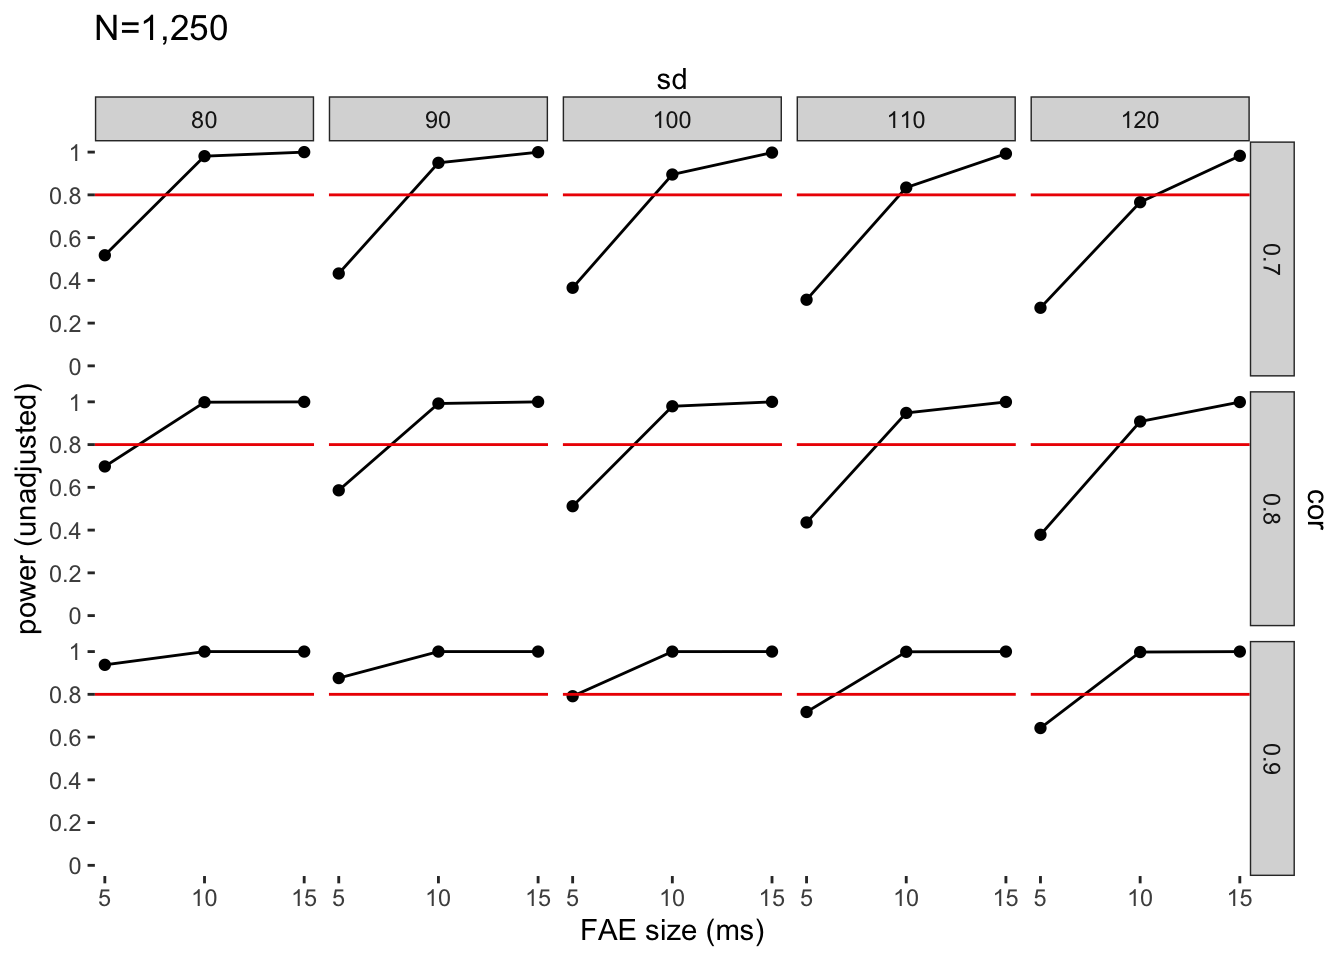

In [ ]:
#| label: fig-power-1250
#| fig-cap: "Power simulations with a sample size of 1,250, for all combinations of standard deviation (sd), pairwise correlation (cor), and interaction effect size. The red line identifies the threshold of 80% power."

library(tidyverse)